In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


📥 Loading PanNuke Fold 2 data...
Pool size: 2523 tiles available.
Image Shape: (2523, 256, 256, 3) (RGB)
Mask Shape: (2523, 256, 256, 6) (5 Cell Types + Backgr)

--- Stitching Indices: [2360 2133 2311  901] ---

✅ PanNuke Mosaic Created (512x512)
Image Shape: (512, 512, 3) uint16
Mask Shape: (512, 512)
Total Unique Cells: 123


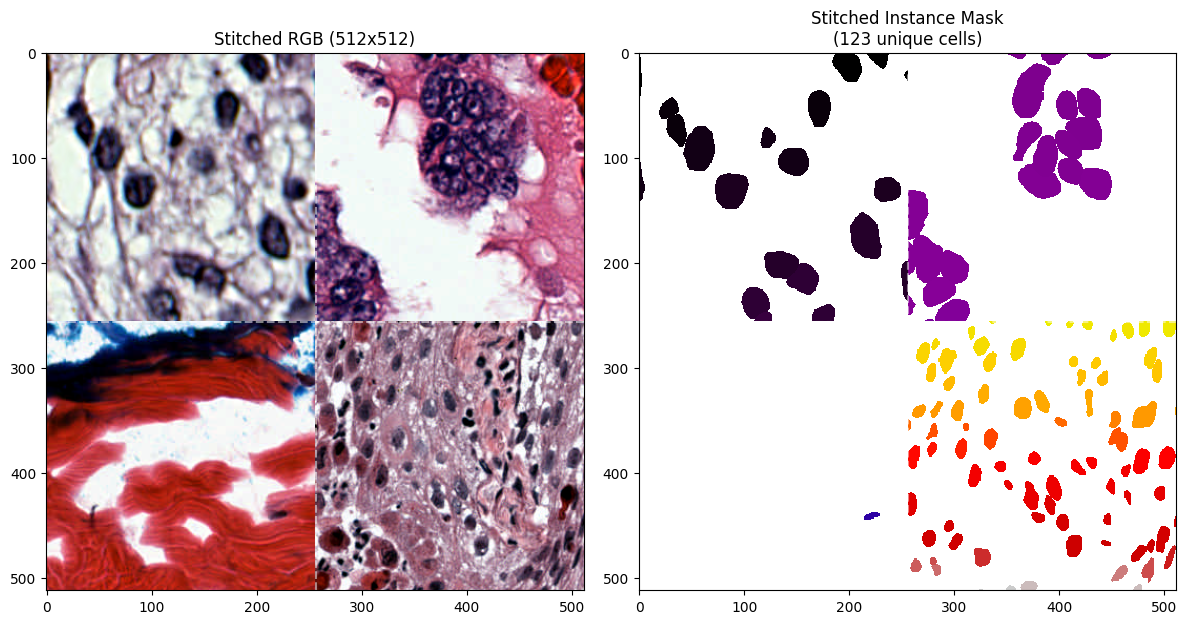

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------
# 1. Load Data (PanNuke)
# ---------------------------------------------------------------------
pannuke_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/PanNuke")
fold2_path = pannuke_path / "Fold 2"

images_npy = fold2_path / "images/fold2/images.npy"
masks_npy = fold2_path / "masks/fold2/masks.npy"

print("📥 Loading PanNuke Fold 2 data...")
# mmap_mode='r' allows us to access parts of the array without loading it all into RAM
raw_images = np.load(images_npy, mmap_mode='r') 
raw_masks = np.load(masks_npy, mmap_mode='r')   

print(f"Pool size: {len(raw_images)} tiles available.")
print(f"Image Shape: {raw_images.shape} (RGB)")
print(f"Mask Shape: {raw_masks.shape} (5 Cell Types + Backgr)")

# ---------------------------------------------------------------------
# 2. PanNuke Mosaic Stitching Function
# ---------------------------------------------------------------------
def create_pannuke_mosaic(indices, images, masks):
    """
    Stitches 4 PanNuke samples (256x256) into one 512x512 patch.
    indices: list of 4 integers [TL, TR, BL, BR]
    """
    # Initialize 512x512 arrays
    # RGB Image (3 channels) -> uint16
    mosaic_img = np.zeros((512, 512, 3), dtype=np.uint16)
    
    # Combined Instance Mask (1 channel, int32)
    # We will combine the 5 cell-type channels into one map
    mosaic_instances = np.zeros((512, 512), dtype=np.int32)
    
    # Coordinates for the 4 quadrants (y_start, y_end, x_start, x_end)
    quadrants = [
        (0, 256, 0, 256),       # Top-Left
        (0, 256, 256, 512),     # Top-Right
        (256, 512, 0, 256),     # Bottom-Left
        (256, 512, 256, 512)    # Bottom-Right
    ]
    
    current_max_id = 0
    
    print(f"\n--- Stitching Indices: {indices} ---")
    
    for i, idx in enumerate(indices):
        y1, y2, x1, x2 = quadrants[i]
        
        # Get source data
        src_img = images[idx]  # (256, 256, 3)
        src_mask_multi = masks[idx] # (256, 256, 6)
        
        # --- A. Process Image (Normalize RGB to uint16) ---
        img_uint16 = np.zeros((256, 256, 3), dtype=np.uint16)
        
        # Normalize each RGB channel independently or globally
        for c in range(3):
            ch = src_img[:, :, c]
            if ch.max() > ch.min():
                # Robust normalization (1st-99th percentile) to fix contrast
                p1, p99 = np.percentile(ch, [1, 99])
                norm = np.clip((ch - p1) / (p99 - p1), 0, 1)
                img_uint16[:, :, c] = (norm * 65535).astype(np.uint16)
            else:
                img_uint16[:, :, c] = ch.astype(np.uint16)
        
        mosaic_img[y1:y2, x1:x2] = img_uint16
        
        # --- B. Process Masks (Collapse 5 channels -> 1 & Offset IDs) ---
        # PanNuke channels 0-4 are cell types. Channel 5 is background.
        # We take the max across channels 0-4 to flatten them into one 2D map.
        # (Assuming pixels don't belong to multiple cell types simultaneously)
        flat_mask = np.max(src_mask_multi[:, :, :5], axis=-1).astype(np.int32)
        
        mask_shifted = np.zeros_like(flat_mask, dtype=np.int32)
        mask_active = flat_mask > 0
        
        if np.any(mask_active):
            # Shift IDs by current_max so they don't clash with previous tiles
            mask_shifted[mask_active] = flat_mask[mask_active] + current_max_id
            
        mosaic_instances[y1:y2, x1:x2] = mask_shifted
        
        # Update max ID for the next quadrant
        if np.any(mask_active):
            current_max_id += flat_mask.max()
            
    return mosaic_img, mosaic_instances

# ---------------------------------------------------------------------
# 3. Test & Visualize
# ---------------------------------------------------------------------
# Pick 4 random indices
random_indices = np.random.choice(len(raw_images), 4, replace=False)
final_img, final_mask = create_pannuke_mosaic(random_indices, raw_images, raw_masks)

print(f"\n✅ PanNuke Mosaic Created (512x512)")
print(f"Image Shape: {final_img.shape} {final_img.dtype}")
print(f"Mask Shape: {final_mask.shape}")
print(f"Total Unique Cells: {len(np.unique(final_mask)) - 1}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show RGB Image
# We divide by 65535 to show it as float 0-1 for matplotlib
axes[0].imshow(final_img.astype(float) / 65535.0)
axes[0].set_title("Stitched RGB (512x512)")
axes[0].axhline(256, color='white', linestyle='--', alpha=0.5)
axes[0].axvline(256, color='white', linestyle='--', alpha=0.5)

# Show Instance Mask
masked_nuclei = np.ma.masked_where(final_mask == 0, final_mask)
axes[1].imshow(masked_nuclei, cmap='nipy_spectral', interpolation='nearest')
axes[1].set_title(f"Stitched Instance Mask\n({len(np.unique(final_mask))-1} unique cells)")
axes[1].axhline(256, color='white', linestyle='--', alpha=0.5)
axes[1].axvline(256, color='white', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [1]:
import os
import numpy as np
import zarr
import pandas as pd
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
pannuke_base = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/PanNuke")
output_base_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/pannuke/zarr_data")

# PanNuke is strictly 256x256 tiles, so we always stitch 4 -> 512x512
patch_size = 512
num_workers = 64 
VAL_SPLIT = 0.10  # 10% for validation
SEED = 42

np.random.seed(SEED)

# ---------------------------------------------------------------------
# 2. Helper Functions
# ---------------------------------------------------------------------
def save_zarr_pannuke(path, img, nuc, metadata):
    """Helper to write Zarr files to disk."""
    os.makedirs(path, exist_ok=True)
    
    # 1. Images (RGB, 3 channels) - FORCED uint8
    z_img = zarr.open(
        str(path / 'images.zarr'), 
        mode='w', 
        shape=(1, 512, 512, 3), 
        chunks=(1, 512, 512, 3), 
        dtype='uint8', 
        compressor=zarr.Blosc(cname='zstd', clevel=3)
    )
    z_img[0] = img

    # 2. Nuclei Masks (1 channel, Instance Segmentation)
    z_nuc = zarr.open(
        str(path / 'nuclei_masks.zarr'), 
        mode='w', 
        shape=(1, 512, 512), 
        chunks=(1, 512, 512), 
        dtype='int32', 
        compressor=zarr.Blosc(cname='zstd', clevel=3)
    )
    z_nuc[0] = nuc
    
    # Metadata
    pd.DataFrame([metadata]).to_csv(path / 'metadata.csv', index=False)

def process_pannuke_mosaic(args):
    """Stitch 4 (256x256) PanNuke tiles into 1 (512x512) sample."""
    # new_index is the sequential ID for the output filename (0, 1, 2...)
    new_index, original_fold, original_indices, output_dir, images_chunk, masks_chunk = args
    
    sample_name = f"pannuke_mosaic_{new_index}"
    sample_path = output_dir / sample_name
    
    # Initialize 512x512 arrays
    mosaic_img = np.zeros((512, 512, 3), dtype=np.uint8)
    mosaic_nuclei = np.zeros((512, 512), dtype=np.int32)
    
    quadrants = [
        (0, 256, 0, 256),   # TL
        (0, 256, 256, 512), # TR
        (256, 512, 0, 256), # BL
        (256, 512, 256, 512)# BR
    ]
    
    current_max_nuclei_id = 0
    
    # Loop over the 4 tiles (some might be None if end of dataset)
    for i, relative_idx in enumerate(original_indices):
        if relative_idx is None: continue 
        
        y1, y2, x1, x2 = quadrants[i]
        
        # Get source data from the chunk passed in
        # Note: images_chunk is just the list of 4 images for this mosaic
        src_img = images_chunk[i]       
        src_mask_multi = masks_chunk[i] 
        
        # --- A. Process Image ---
        mosaic_img[y1:y2, x1:x2] = src_img.astype(np.uint8)
        
        # --- B. Process Masks ---
        # Collapse channels 0-4 (cell types) into one instance map
        # Channel 5 is 'background/other' often, usually ignore for instance IDs or handle separately
        flat_mask = np.max(src_mask_multi[:, :, :5], axis=-1).astype(np.int32)
        
        # Shift IDs to prevent collisions between the 4 quadrants
        nuclei_shifted = np.zeros_like(flat_mask, dtype=np.int32)
        mask_active = flat_mask > 0
        
        if np.any(mask_active):
            nuclei_shifted[mask_active] = flat_mask[mask_active] + current_max_nuclei_id
            
        # Place in Mosaic
        mosaic_nuclei[y1:y2, x1:x2] = nuclei_shifted
        
        # Update offsets
        if np.any(mask_active):
            current_max_nuclei_id += flat_mask.max()
        
    meta = {
        'patch_idx': 0, 
        'sample': sample_name, 
        'original_fold': original_fold, 
        'original_indices': str(original_indices) # Helpful for debugging source
    }
    
    save_zarr_pannuke(sample_path, mosaic_img, mosaic_nuclei, meta)
    return True

# ---------------------------------------------------------------------
# 3. Execution Logic
# ---------------------------------------------------------------------
def run_batch_processing(task_list, output_subdir_name, data_sources):
    """
    Args:
        task_list: List of tuples (fold_id, start_index)
        output_subdir_name: e.g., "pannuke_train"
        data_sources: Dict {fold_id: (images_memmap, masks_memmap)}
    """
    output_dir = output_base_path / output_subdir_name
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\n🚀 Generating tasks for {output_subdir_name} ({len(task_list)} mosaics)...")
    
    executor_tasks = []
    
    # We enumerate to give each output a clean ID: 0, 1, 2...
    for i, (fold_id, start_idx) in enumerate(task_list):
        images_all, masks_all = data_sources[fold_id]
        total_len = len(images_all)
        
        # Grab the 4 indices for this mosaic
        batch_indices_global = []
        images_chunk = []
        masks_chunk = []
        
        # Extract the 4 tiles from the massive array
        # We do this here to avoid passing the massive memmap to workers (pickling issues)
        for k in range(4):
            idx = start_idx + k
            if idx < total_len:
                batch_indices_global.append(idx)
                images_chunk.append(images_all[idx]) # Reads from disk/mmap here
                masks_chunk.append(masks_all[idx])
            else:
                batch_indices_global.append(None)
                images_chunk.append(None) # Handle incomplete last mosaic
                masks_chunk.append(None)

        # Filter out Nones for the worker arguments where strict numpy arrays are needed?
        # Actually my worker expects a list of 4 items, some None. 
        # But numpy array creation requires uniform shapes.
        # Let's clean the list for numpy creation, but keep indices for tracking.
        
        valid_imgs = [img for img in images_chunk if img is not None]
        valid_msks = [msk for msk in masks_chunk if msk is not None]
        
        # Re-pad with Nones isn't necessary for the logic inside process_pannuke_mosaic 
        # as long as we iterate 4 times and check indices.
        # BUT, the worker needs the actual data.
        # Let's pass the valid lists directly. The worker will map them based on the indices list.
        
        # We need to structure the args so the worker knows which of the 4 quadrants corresponds to which data
        # Refactoring worker slightly: it iterates `original_indices`. If index is None, it skips quadrant.
        # So we need `images_chunk` to match the length of valid indices.
        
        executor_tasks.append((
            i,                          # New sequential Index
            f"Fold_{fold_id}",          # Original Fold Name
            batch_indices_global,       # [100, 101, 102, 103] or [..., None]
            output_dir,
            valid_imgs,                 # Only the valid arrays
            valid_msks
        ))

    print(f"   Starting Executor for {output_subdir_name}...")
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        list(tqdm(
            executor.map(process_pannuke_mosaic, executor_tasks), 
            total=len(executor_tasks),
            desc=f"Processing {output_subdir_name}"
        ))

# ---------------------------------------------------------------------
# 4. Main
# ---------------------------------------------------------------------
if __name__ == "__main__":
    
    print(f"{'='*60}")
    print(f"🔬 PanNuke Split: Fold1+2 (Train/Val) | Fold3 (Test)")
    print(f"{'='*60}")
    
    # --- Step 1: Load Data Sources (Lazy Load) ---
    data_sources = {}
    folds_to_load = [1, 2, 3]
    
    for fold in folds_to_load:
        fold_dir = f"Fold {fold}" # Folder names on disk are "Fold 1", "Fold 2"
        img_path = pannuke_base / fold_dir / f"images/fold{fold}/images.npy"
        mask_path = pannuke_base / fold_dir / f"masks/fold{fold}/masks.npy"
        
        if img_path.exists():
            print(f"📂 Mapping Fold {fold}...")
            # mmap_mode='r' keeps memory usage low
            data_sources[fold] = (
                np.load(img_path, mmap_mode='r'), 
                np.load(mask_path, mmap_mode='r')
            )
        else:
            print(f"❌ Fold {fold} missing at {img_path}")

    # --- Step 2: Create Mosaic Index Lists ---
    # We process in groups of 4 (Mosaic). 
    # Logic: Identify (FoldID, StartIndex) for every possible mosaic.
    
    train_pool_tasks = [] # Will contain Fold 1 and Fold 2
    test_tasks = []       # Will contain Fold 3
    
    # Collect Fold 1 and 2
    for fold in [1, 2]:
        if fold in data_sources:
            n_samples = len(data_sources[fold][0])
            # Range step 4
            for start_idx in range(0, n_samples, 4):
                train_pool_tasks.append((fold, start_idx))
                
    # Collect Fold 3 (Test)
    if 3 in data_sources:
        n_samples = len(data_sources[3][0])
        for start_idx in range(0, n_samples, 4):
            test_tasks.append((3, start_idx))

    # --- Step 3: Shuffle and Split Train/Val ---
    print(f"\n📊 Splitting Data...")
    np.random.shuffle(train_pool_tasks)
    
    n_total_train_pool = len(train_pool_tasks)
    n_val = int(n_total_train_pool * VAL_SPLIT)
    n_train = n_total_train_pool - n_val
    
    train_tasks = train_pool_tasks[:n_train]
    val_tasks = train_pool_tasks[n_train:]
    
    print(f"   Train (Fold 1+2 subset): {len(train_tasks)} mosaics")
    print(f"   Val   (Fold 1+2 subset): {len(val_tasks)} mosaics")
    print(f"   Test  (Fold 3)         : {len(test_tasks)} mosaics")

    # --- Step 4: Execute ---
    
    if train_tasks:
        run_batch_processing(train_tasks, "pannuke_train", data_sources)
        
    if val_tasks:
        run_batch_processing(val_tasks, "pannuke_val", data_sources)
        
    if test_tasks:
        run_batch_processing(test_tasks, "pannuke_test", data_sources)

    print(f"\n{'='*60}")
    print("🎉 ALL DONE")

🔬 PanNuke Split: Fold1+2 (Train/Val) | Fold3 (Test)
📂 Mapping Fold 1...
📂 Mapping Fold 2...
📂 Mapping Fold 3...

📊 Splitting Data...
   Train (Fold 1+2 subset): 1166 mosaics
   Val   (Fold 1+2 subset): 129 mosaics
   Test  (Fold 3)         : 681 mosaics

🚀 Generating tasks for pannuke_train (1166 mosaics)...
   Starting Executor for pannuke_train...


Processing pannuke_train: 100%|██████████| 1166/1166 [03:47<00:00,  5.12it/s]


🚀 Generating tasks for pannuke_val (129 mosaics)...
   Starting Executor for pannuke_val...



Processing pannuke_val: 100%|██████████| 129/129 [00:28<00:00,  4.53it/s]



🚀 Generating tasks for pannuke_test (681 mosaics)...
   Starting Executor for pannuke_test...


Processing pannuke_test: 100%|██████████| 681/681 [01:48<00:00,  6.27it/s]


🎉 ALL DONE


## Test

🔎 Inspecting PanNuke Path: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/pannuke/zarr_data/Fold1/pannuke_mosaic_0
🔎 Comparing against Xenium Sample: breast

🧬 STRUCTURAL COMPARISON
PanNuke: (1, 512, 512, 3) | uint8 | Range: 28-255
Xenium:  (145, 512, 512, 3) | uint8 | Range: 0-255

👁️ VISUAL INTEGRITY CHECK


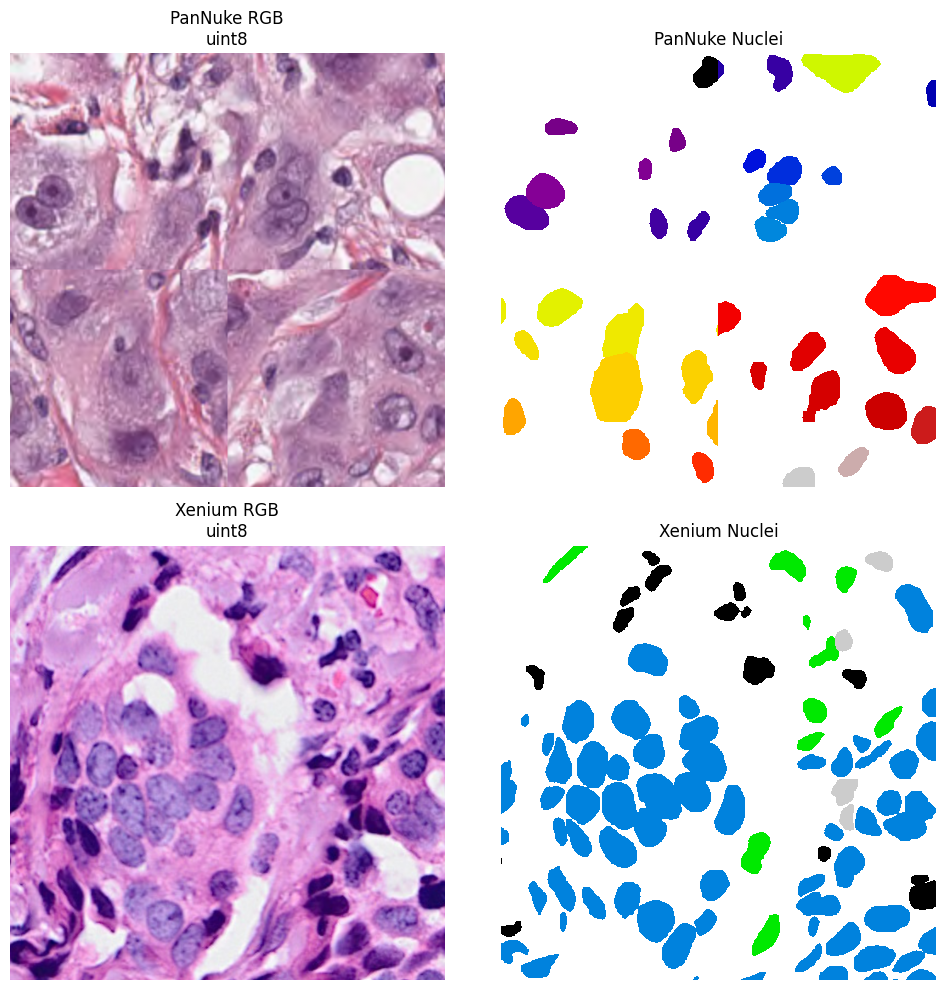

In [20]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
pannuke_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/pannuke/zarr_data/Fold1/pannuke_mosaic_0"
xenium_base_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/Xenium/zarr_data"

# Find Xenium sample
if os.path.exists(xenium_base_path):
    xenium_samples = sorted([d for d in os.listdir(xenium_base_path) 
                             if os.path.isdir(os.path.join(xenium_base_path, d))])
    xenium_sample_path = os.path.join(xenium_base_path, xenium_samples[0]) if xenium_samples else None
else:
    xenium_sample_path = None

print(f"🔎 Inspecting PanNuke Path: {pannuke_path}")
if xenium_sample_path: print(f"🔎 Comparing against Xenium Sample: {os.path.basename(xenium_sample_path)}")

# ---------------------------------------------------------------------
# 2. Metadata Extraction
# ---------------------------------------------------------------------
def get_he_info(path, label="Dataset"):
    info = {'exists': False, 'label': label}
    
    # Locate images.zarr
    paths_to_check = [os.path.join(path, 'he'), path, os.path.join(path, 'mif')]
    target_path = next((p for p in paths_to_check if os.path.exists(os.path.join(p, 'images.zarr'))), None)

    if not target_path:
        info['error'] = "images.zarr not found"
        return info

    try:
        img = zarr.open(os.path.join(target_path, 'images.zarr'), mode='r')
        nuc_path = os.path.join(target_path, 'nuclei_masks.zarr')
        nuc = zarr.open(nuc_path, mode='r') if os.path.exists(nuc_path) else None

        info.update({
            'exists': True, 'final_path': target_path,
            'img_shape': img.shape, 'img_dtype': img.dtype,
            'sample_img': img[0], 'has_mask': nuc is not None
        })
        
        if nuc is not None:
            info.update({'mask_dtype': nuc.dtype, 'sample_nuc': nuc[0], 'nuc_max_id': np.max(nuc[0])})
        else:
            info.update({'mask_dtype': "N/A", 'sample_nuc': np.zeros(img.shape[1:3]), 'nuc_max_id': 0})

    except Exception as e:
        info['error'] = str(e)
        
    return info

pn_info = get_he_info(pannuke_path, label="PanNuke")
xen_info = get_he_info(xenium_sample_path, label="Xenium") if xenium_sample_path else None

# ---------------------------------------------------------------------
# 3. Report & Visuals
# ---------------------------------------------------------------------
print("\n" + "="*80 + "\n🧬 STRUCTURAL COMPARISON\n" + "="*80)

# Report
if pn_info['exists']:
    print(f"PanNuke: {pn_info['img_shape']} | {pn_info['img_dtype']} | Range: {pn_info['sample_img'].min()}-{pn_info['sample_img'].max()}")

if xen_info and xen_info['exists']:
    print(f"Xenium:  {xen_info['img_shape']} | {xen_info['img_dtype']} | Range: {xen_info['sample_img'].min()}-{xen_info['sample_img'].max()}")
    
    if pn_info['img_dtype'] != xen_info['img_dtype']:
        print("\n⚠️ WARNING: Dtype mismatch! Your Dataloader must handle this.")
else:
    print("\n❌ Xenium Reference not found.")

# Visualization
print("\n" + "="*80 + "\n👁️ VISUAL INTEGRITY CHECK\n" + "="*80)

if pn_info['exists']:
    rows = 2 if (xen_info and xen_info['exists']) else 1
    fig, axes = plt.subplots(rows, 2, figsize=(10, 5 * rows))
    if rows == 1: axes = np.expand_dims(axes, axis=0)

    # Helper to normalize display based on dtype
    def show_img(ax, img, title):
        # Auto-detect range for display
        if img.max() > 255:
            norm_img = img.astype(float) / 65535.0 # uint16
        elif img.dtype == np.uint8 or img.max() > 1.0:
            norm_img = img.astype(float) / 255.0   # uint8 or float 0-255
        else:
            norm_img = img # float 0-1
            
        ax.imshow(norm_img)
        ax.set_title(title)
        ax.axis('off')

    # PanNuke
    show_img(axes[0, 0], pn_info['sample_img'], f"PanNuke RGB\n{pn_info['img_dtype']}")
    axes[0, 1].imshow(np.ma.masked_where(pn_info['sample_nuc'] == 0, pn_info['sample_nuc']), cmap='nipy_spectral', interpolation='nearest')
    axes[0, 1].set_title("PanNuke Nuclei")
    axes[0, 1].axis('off')

    # Xenium
    if rows > 1:
        xen_img = xen_info['sample_img']
        # Handle Grayscale vs RGB for Xenium
        if xen_img.ndim == 3 and xen_img.shape[2] == 3:
            show_img(axes[1, 0], xen_img, f"Xenium RGB\n{xen_info['img_dtype']}")
        else:
            axes[1, 0].imshow(xen_img, cmap='gray')
            axes[1, 0].set_title(f"Xenium Gray/DAPI\n{xen_info['img_dtype']}")
            axes[1, 0].axis('off')

        axes[1, 1].imshow(np.ma.masked_where(xen_info['sample_nuc'] == 0, xen_info['sample_nuc']), cmap='nipy_spectral', interpolation='nearest')
        axes[1, 1].set_title("Xenium Nuclei")
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()